## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

### STEP 1: TOKENIZATION

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

## THE FINAL GPT CODE


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

### THE BUILDING BLOCKS: LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURAL NETWORK

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

## THE TRANSFORMER BLOCK

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


## GENERATING TEXT FROM OUTPUT TOKENS

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
    ###tensor([[6109, 3626, 6100,  345],
            ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() #A
#model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


### Our first output from our GPT ( NOT YET TRAINED ) so its obivious to get non sense outputs , but still we are getting something.

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


### Thats okay, let's train it then.

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


### Data loader

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

Not enough tokens for the validation loader. Try to lower the `GPT_CONFIG_124M['context_length']` or decrease the `training_ratio`


In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])

Validation loader:
2
0


### Here we can see that , the train data is not big enough so we are lowering our GPTs context length

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### Okay as we now implemented the data loaders and the data is ready to feed in , but how do we know that our model is learning ??

### Thats where Loss functions comes in , we are using cross entropy

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98850186665853
Validation loss: 10.990342140197754


### The Above is the intial loss , lets see how we the loss function decreases.



In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=10,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.768, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.726, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.102, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.604, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.422, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.007, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.585, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.112, Val loss 6.165
Every effort moves you know                                         

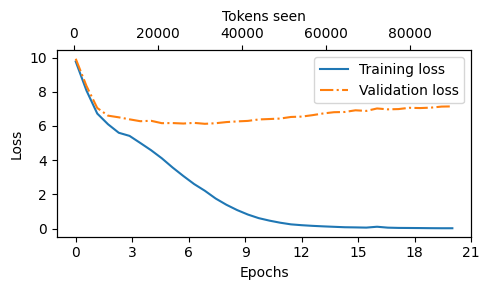

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
# print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
# print("encoded_tensor.shape:", encoded_tensor.shape)

model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=4,
context_size=GPT_CONFIG_124M["context_length"]
)
# print("Output:", out)
# print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(start_context)
print(decoded_text)

Hello, I am
Hello, I am Guminois employees teacher


In [ ]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

### So yes, over model is slightly better now. But this is no where near to a bare minimum model , so we are taking the weights from the OPEN AI , which they have publically released.

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

In [56]:

def download_and_load_gpt2(model_size, models_dir):
    # Validate model sizepython -c "import tensorflow as tf; print(tf.__version__)"

    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    ## We have reached here until now ---> we have downloaded the files on our local machine.

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

def download_file(url, destination):
    try:
        # Send a GET request to download the file, disabling SSL verification
        response = requests.get(url, stream=True, verify=False)

        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("content-length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = url.split("/")[-1]  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Iterate over the file data in chunks
                for chunk in response.iter_content(block_size):
                    progress_bar.update(len(chunk))  # Update progress bar
                    file.write(chunk)  # Write the chunk to the file

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        print(f"Please check the URL: {url}")

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


In [57]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 116kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 654kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [58]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [59]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [60]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [61]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [62]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [67]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [73]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward. If a situation requires urgent attention and you don't feel well-adjusted to handle things this is not always a good
